In [50]:
import gym
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
import random
import dill as pickle
%matplotlib inline

In [92]:
"""
@author: Olivier Sigaud
A merge between two sources:
* Adaptation of the MountainCar Environment from the "FAReinforcement" library
of Jose Antonio Martin H. (version 1.0), adapted by  'Tom Schaul, tom@idsia.ch'
and then modified by Arnaud de Broissia
* the gym MountainCar environment
itself from
http://incompleteideas.net/sutton/MountainCar/MountainCar1.cp
permalink: https://perma.cc/6Z2N-PFWC
"""

import math
from typing import Optional

import numpy as np

import gym
from gym import spaces, logger
from gym.envs.classic_control import utils
from gym.utils import seeding
from gym.error import DependencyNotInstalled
import pysindy as ps


class MountainCarEnv(gym.Env):
    """
    ### Description
    The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically
    at the bottom of a sinusoidal valley, with the only possible actions being the accelerations
    that can be applied to the car in either direction. The goal of the MDP is to strategically
    accelerate the car to reach the goal state on top of the right hill. There are two versions
    of the mountain car domain in gym: one with discrete actions and one with continuous.
    This version is the one with continuous actions.
    This MDP first appeared in [Andrew Moore's PhD Thesis (1990)](https://www.cl.cam.ac.uk/techreports/UCAM-CL-TR-209.pdf)
    ```
    @TECHREPORT{Moore90efficientmemory-based,
        author = {Andrew William Moore},
        title = {Efficient Memory-based Learning for Robot Control},
        institution = {University of Cambridge},
        year = {1990}
    }
    ```
    ### Observation Space
    The observation is a `ndarray` with shape `(2,)` where the elements correspond to the following:
    | Num | Observation                          | Min  | Max | Unit         |
    |-----|--------------------------------------|------|-----|--------------|
    | 0   | position of the car along the x-axis | -Inf | Inf | position (m) |
    | 1   | velocity of the car                  | -Inf | Inf | position (m) |
    ### Action Space
    The action is a `ndarray` with shape `(1,)`, representing the directional force applied on the car.
    The action is clipped in the range `[-1,1]` and multiplied by a power of 0.0015.
    ### Transition Dynamics:
    Given an action, the mountain car follows the following transition dynamics:
    *velocity<sub>t+1</sub> = velocity<sub>t+1</sub> + force * self.power - 0.0025 * cos(3 * position<sub>t</sub>)*
    *position<sub>t+1</sub> = position<sub>t</sub> + velocity<sub>t+1</sub>*
    where force is the action clipped to the range `[-1,1]` and power is a constant 0.0015.
    The collisions at either end are inelastic with the velocity set to 0 upon collision with the wall.
    The position is clipped to the range [-1.2, 0.6] and velocity is clipped to the range [-0.07, 0.07].
    ### Reward
    A negative reward of *-0.1 * action<sup>2</sup>* is received at each timestep to penalise for
    taking actions of large magnitude. If the mountain car reaches the goal then a positive reward of +100
    is added to the negative reward for that timestep.
    ### Starting State
    The position of the car is assigned a uniform random value in `[-0.6 , -0.4]`.
    The starting velocity of the car is always assigned to 0.
    ### Episode End
    The episode ends if either of the following happens:
    1. Termination: The position of the car is greater than or equal to 0.45 (the goal position on top of the right hill)
    2. Truncation: The length of the episode is 999.
    ### Arguments
    ```
    gym.make('MountainCarContinuous-v0')
    ```
    ### Version History
    * v0: Initial versions release (1.0.0)
    """

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 30,
    }

    def __init__(self, render_mode=None, goal_velocity=0, use_sindy=False, model=None):
        self.min_action = -1.0
        self.max_action = 1.0
        self.min_position = -1.2
        self.max_position = 0.6
        self.max_speed = 0.07
        self.goal_position = (
            0.45  # was 0.5 in gym, 0.45 in Arnaud de Broissia's version
        )
        self.goal_velocity = goal_velocity
        self.power = 0.0015

        self.low_state = np.array(
            [self.min_position, -self.max_speed], dtype=np.float32
        )
        self.high_state = np.array(
            [self.max_position, self.max_speed], dtype=np.float32
        )

        self.render_mode = render_mode

        self.screen_width = 600
        self.screen_height = 400
        self.screen = None
        self.clock = None
        self.isopen = True

        self.action_space = spaces.Box(
            low=self.min_action, high=self.max_action, shape=(1,), dtype=np.float32
        )
        self.observation_space = spaces.Box(
            low=self.low_state, high=self.high_state, dtype=np.float32
        )

        self.model = model
        self.use_sindy = use_sindy
        self.np_random, seed = seeding.np_random(None)

    def step(self, action):

        position = self.state[0]
        velocity = self.state[1]
        force = min(max(action[0], self.min_action), self.max_action)


        if self.model is None:
            velocity += force * self.power - 0.0025 * math.cos(3 * position)
            if velocity > self.max_speed:
                velocity = self.max_speed
            if velocity < -self.max_speed:
                velocity = -self.max_speed
            position += velocity
            if position > self.max_position:
                position = self.max_position
            if position < self.min_position:
                position = self.min_position
            if position == self.min_position and velocity < 0:
                velocity = 0
        else:
            state_vec = np.array([[position, velocity]])
            action_vec = np.array([action])
            # print(state_vec, action_vec)
            new_state = self.model.predict(state_vec, u=action_vec)
            position, velocity = new_state[0]
            if velocity > self.max_speed:
                velocity = self.max_speed
            if velocity < -self.max_speed:
                velocity = -self.max_speed
            if position > self.max_position:
                position = self.max_position
            if position < self.min_position:
                position = self.min_position
            if position == self.min_position and velocity < 0:
                velocity = 0

        # Convert a possible numpy bool to a Python bool.
        terminated = bool(
            position >= self.goal_position and velocity >= self.goal_velocity
        )

        reward = 0
        if terminated:
            reward = 100.0
        reward -= math.pow(action[0], 2) * 0.1

        self.state = np.array([position, velocity], dtype=object)

        if self.render_mode == "human":
            self.render()
        return self.state, reward, terminated, {}

    def reset(self, *, seed=None, options=None):
        # Note that if you use custom reset bounds, it may lead to out-of-bound
        # state/observations.
        low, high = utils.maybe_parse_reset_bounds(options, -0.6, -0.4)
#         self.state = np.array([self.np_random.uniform(low=low, high=high), 0], dtype=np.float32)
        self.state = np.array([-0.5, 0.])

        if self.render_mode == "human":
            self.render()
        return self.state

    def _height(self, xs):
        return np.sin(3 * xs) * 0.45 + 0.55

    def render(self):
        if self.render_mode is None:
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[classic_control]`"
            )

        if self.screen is None:
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode(
                    (self.screen_width, self.screen_height)
                )
            else:  # mode == "rgb_array":
                self.screen = pygame.Surface((self.screen_width, self.screen_height))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        world_width = self.max_position - self.min_position
        scale = self.screen_width / world_width
        carwidth = 40
        carheight = 20

        self.surf = pygame.Surface((self.screen_width, self.screen_height))
        self.surf.fill((255, 255, 255))

        pos = self.state[0]

        xs = np.linspace(self.min_position, self.max_position, 100)
        ys = self._height(xs)
        xys = list(zip((xs - self.min_position) * scale, ys * scale))

        pygame.draw.aalines(self.surf, points=xys, closed=False, color=(0, 0, 0))

        clearance = 10

        l, r, t, b = -carwidth / 2, carwidth / 2, carheight, 0
        coords = []
        for c in [(l, b), (l, t), (r, t), (r, b)]:
            c = pygame.math.Vector2(c).rotate_rad(math.cos(3 * pos))
            coords.append(
                (
                    c[0] + (pos - self.min_position) * scale,
                    c[1] + clearance + self._height(pos) * scale,
                )
            )

        gfxdraw.aapolygon(self.surf, coords, (0, 0, 0))
        gfxdraw.filled_polygon(self.surf, coords, (0, 0, 0))

        for c in [(carwidth / 4, 0), (-carwidth / 4, 0)]:
            c = pygame.math.Vector2(c).rotate_rad(math.cos(3 * pos))
            wheel = (
                int(c[0] + (pos - self.min_position) * scale),
                int(c[1] + clearance + self._height(pos) * scale),
            )

            gfxdraw.aacircle(
                self.surf, wheel[0], wheel[1], int(carheight / 2.5), (128, 128, 128)
            )
            gfxdraw.filled_circle(
                self.surf, wheel[0], wheel[1], int(carheight / 2.5), (128, 128, 128)
            )

        flagx = int((self.goal_position - self.min_position) * scale)
        flagy1 = int(self._height(self.goal_position) * scale)
        flagy2 = flagy1 + 50
        gfxdraw.vline(self.surf, flagx, flagy1, flagy2, (0, 0, 0))

        gfxdraw.aapolygon(
            self.surf,
            [(flagx, flagy2), (flagx, flagy2 - 10), (flagx + 25, flagy2 - 5)],
            (204, 204, 0),
        )
        gfxdraw.filled_polygon(
            self.surf,
            [(flagx, flagy2), (flagx, flagy2 - 10), (flagx + 25, flagy2 - 5)],
            (204, 204, 0),
        )

        self.surf = pygame.transform.flip(self.surf, False, True)
        self.screen.blit(self.surf, (0, 0))
        if self.render_mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()

        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False

    def use_sindy_model(self):
        print('started sindy training')
        env = gym.make('MountainCarContinuous-v0')

        trajectories = []
        actions = []
        num_trajs = 100
        for traj in range(num_trajs):
            env.reset()
            obs = []
            ac = []
            for i in range(1000):
                a = env.action_space.sample()
                ob, reward, terminated = env.step(a)[:3]
                if terminated:
                    break
                obs.append(ob)
                ac.append(a)
            trajectories.append(np.array(obs))
            actions.append(np.array(ac))
        optimizer = ps.SR3(threshold=0.0001, max_iter=10000)
        der = ps.SmoothedFiniteDifference()
            
        model = ps.SINDy(discrete_time=True, optimizer=optimizer,
                        differentiation_method=der,
                        feature_library=ps.ConcatLibrary([ps.FourierLibrary(), 
                                                        ps.PolynomialLibrary()]))
        model.fit(x=trajectories,u=actions,multiple_trajectories=True)
        self.model = model
        print('finished sindy training, score = ', model.score(trajectories,u=actions,multiple_trajectories=True))

In [93]:
def get_screen():
    ''' Extract one step of the simulation.'''
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255.
    return torch.from_numpy(screen)

Creating the transition function
998
998
998


/Users/agnimagarwal/opt/anaconda3/lib/python3.9/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/var/folders/13/9ylnh3d93p713zhkf6kdgzyr0000gn/T/ipykernel_53896/3654631334.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(state_action), np.array(states), np.array(actions)


998
998
998
998
998
998
998
(x0)[k+1] = -0.031 sin(1 x0[k]) + -0.065 cos(1 x0[k]) + 0.011 sin(1 x1[k]) + 13.782 cos(1 x1[k]) + -13.719 1 + 1.031 x0[k] + 0.989 x1[k] + 0.001 u0[k] + -0.020 x0[k]^2 + 6.891 x1[k]^2
(x1)[k+1] = -0.031 sin(1 x0[k]) + -0.065 cos(1 x0[k]) + 0.011 sin(1 x1[k]) + 13.782 cos(1 x1[k]) + -13.719 1 + 0.031 x0[k] + 0.989 x1[k] + 0.001 u0[k] + -0.020 x0[k]^2 + 6.891 x1[k]^2
0.9999998537456753


/Users/agnimagarwal/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.47517e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/agnimagarwal/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.47517e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/agnimagarwal/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.50938e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/agnimagarwal/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.50938e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


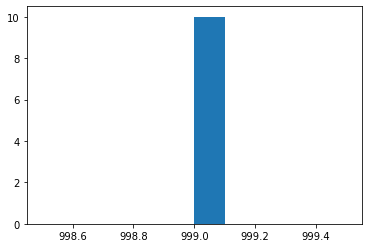

In [192]:
def runEpisodeBB(heuristic=True, agent=None):
    env = gym.make("MountainCarContinuous-v0")
    obs = env.reset()
    state_action = []
    states = []
    actions = []
    num_episodes = 0
    k = 2
    action = env.action_space.sample()
    action = env.action_space.sample()
    for i in range(100000):
        if heuristic:
            action = 1
            # action = env.action_space.sample() if np.random.uniform() < 0.2 else action
        if agent == None:
            curr_action = action
            action = -1*action
            action = env.action_space.sample()
        else:
            action = agent.select_action(obs, evaluate=True)
        #temp = 10 if action == 1 else -10
        state_action.append([*obs, action])
        states.append([*obs])
        actions.append(action)
        next_obs, reward, done = env.step(action)[:3]
        obs = np.copy(next_obs)
        if done:
            print(i)
            obs, _ = env.reset()
            num_episodes += 1
            if num_episodes == 1:
                break
    # print("Number of episodes in data collection ", num_episodes)
    return np.array(state_action), np.array(states), np.array(actions)

def create_transitionfunction(agent=None, num_trajs=1):
    states = []
    actions = []
    print("Creating the transition function")
    for i in range(num_trajs):
        xva, state, action = runEpisodeBB(agent)
        states.append(state)
        actions.append(action)
 
#     functions = [lambda x : 1, lambda x : x, lambda x : x**2,  lambda x: np.sin(x), lambda x : np.cos(x), 
#                 lambda x: np.sin(2*x), lambda x : np.cos(2*x), lambda x: np.sin(3*x), lambda x : np.cos(3*x)]
#     lib = ps.CustomLibrary(library_functions=functions)
    lib = ps.ConcatLibrary([ps.FourierLibrary(), ps.PolynomialLibrary()])
    guess = np.zeros((2,27))
    optimizer = ps.optimizers.STLSQ(threshold=0.0001, alpha=0)
    #lib = PolynomialLibrary()
    der = ps.SINDyDerivative()
    der = ps.SmoothedFiniteDifference()
    model = ps.SINDy(discrete_time=True, feature_library=lib, differentiation_method=der,
                optimizer=optimizer)
    model.fit(states, u=actions, multiple_trajectories=True)
    model.print()
    print(model.score(states, u=actions, multiple_trajectories=True))
    plt.hist([len(state) for state in states])
    return model

model = create_transitionfunction(num_trajs=10)

In [167]:
# with open('../model.pkl', 'wb') as f:
#     pickle.dump(model, f)

In [188]:
sindy_env = MountainCarEnv(model=model)
gt_env = MountainCarEnv(model=None)

/Users/agnimagarwal/opt/anaconda3/lib/python3.9/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


/var/folders/13/9ylnh3d93p713zhkf6kdgzyr0000gn/T/ipykernel_53896/2102935785.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(state_action), np.array(states), np.array(actions)


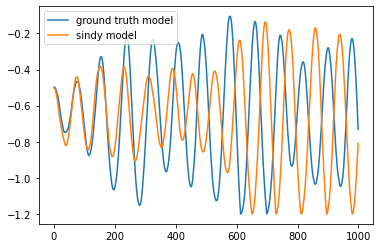

In [189]:
import numpy as np
import matplotlib.pyplot as plt
def runEpisodeBB(env, heuristic=True, agent=None):
    obs = env.reset()
    state_action = []
    states = []
    actions = []
    num_episodes = 0
    k = 2
    action = env.action_space.sample()
    action = env.action_space.sample()
    for i in range(1000):
        if heuristic:
            action = np.array([1])
        if agent == None:
            curr_action = action
            action = -1*action
            action = env.action_space.sample() if np.random.uniform() < 0.5 else action
        else:
            action = agent.select_action(obs, evaluate=True)
        #temp = 10 if action == 1 else -10
        state_action.append([*obs, action])
        states.append([*obs])
        actions.append(action)
        next_obs, reward, done = env.step(action)[:3]
        obs = np.copy(next_obs)
        if done:
            obs, _ = env.reset()
            num_episodes += 1
            if num_episodes == 1:
                break
    # print("Number of episodes in data collection ", num_episodes)
    return np.array(state_action), np.array(states), np.array(actions)

_, sindy_states, sindy_actions = runEpisodeBB(sindy_env)
_, gt_states, gt_actions = runEpisodeBB(gt_env)
plt.plot(gt_states[:,0])
plt.plot(sindy_states[:,0])
plt.legend(['ground truth model', 'sindy model'])